*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [ ]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [ ]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
#dataset.tail()

--2021-07-10 17:29:21--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.01s   

2021-07-10 17:29:21 (4.66 MB/s) - ‘insurance.csv’ saved [50264/50264]



Explore Data

In [ ]:
eda_data = dataset.copy()

In [ ]:
eda_data

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95


In [ ]:
eda_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
eda_data.sex.value_counts()

male      676
female    662
Name: sex, dtype: int64

<BarContainer object of 2 artists>

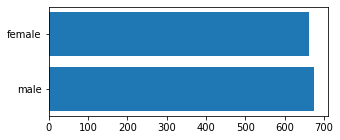

In [ ]:
fig = plt.figure(figsize=(5, 2))

plt.barh((eda_data.sex.value_counts()).keys(), (eda_data.sex.value_counts()).values)

In [ ]:
eda_data.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [ ]:
eda_data.region.value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

<BarContainer object of 4 artists>

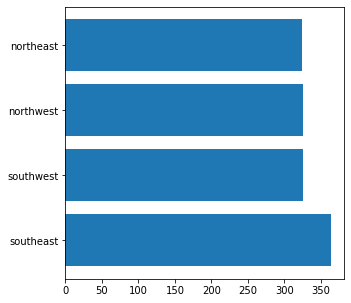

In [ ]:
fig = plt.figure(figsize=(5, 5))

plt.barh((eda_data.region.value_counts()).keys(), (eda_data.region.value_counts()).values)

In [ ]:
eda_data.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


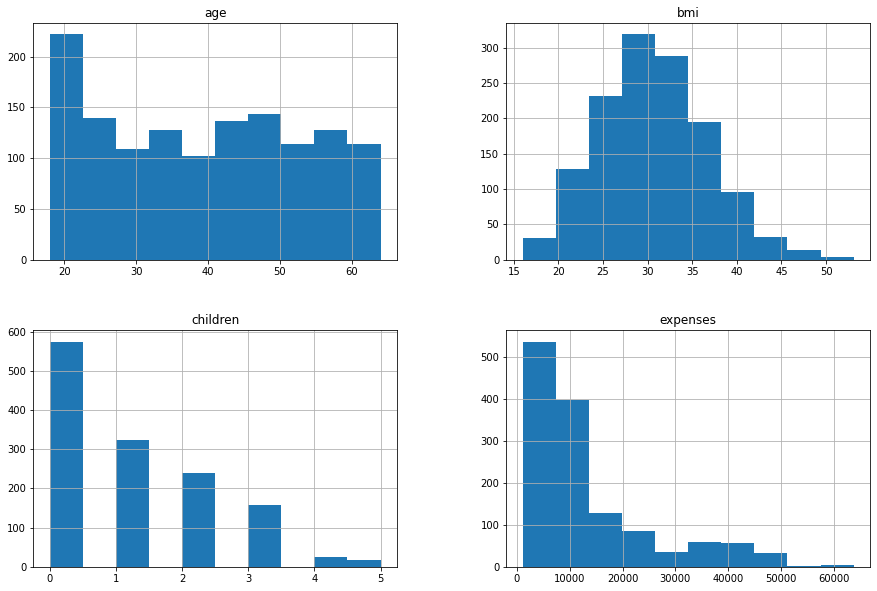

In [ ]:
eda_data.hist(figsize = (15, 10))
plt.show()

In [ ]:
corr_matrix = eda_data.corr()

In [ ]:
corr_matrix.expenses.sort_values(ascending = False)

expenses    1.000000
age         0.299008
bmi         0.198576
children    0.067998
Name: expenses, dtype: float64

In [ ]:
eda_data["sex"] = eda_data["sex"].map({"male": 1, "female": 0})
eda_data["smoker"] = eda_data["smoker"].map({"yes": 1, "no": 0})
eda_data

,age,sex,bmi,children,smoker,region,expenses
0,19,0,27.9,0,1,southwest,16884.92
1,18,1,33.8,1,0,southeast,1725.55
2,28,1,33.0,3,0,southeast,4449.46
3,33,1,22.7,0,0,northwest,21984.47
4,32,1,28.9,0,0,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,1,31.0,3,0,northwest,10600.55
1334,18,0,31.9,0,0,northeast,2205.98
1335,18,0,36.9,0,0,southeast,1629.83
1336,21,0,25.8,0,0,southwest,2007.95


In [ ]:
corr_matrix = eda_data.corr()
corr_matrix.expenses.sort_values(ascending = False)

expenses    1.000000
smoker      0.787251
age         0.299008
bmi         0.198576
children    0.067998
sex         0.057292
Name: expenses, dtype: float64

In [ ]:
eda_data[eda_data.expenses == eda_data.expenses.max()]

,age,sex,bmi,children,smoker,region,expenses
543,54,0,47.4,0,1,southeast,63770.43


It means that a person that has the highest healthcare costs in this dataset it must be smoker and a person that has the lowest healthcare costs in this dataset it must be non-smoker.

In [ ]:
eda_data[eda_data.expenses == eda_data.expenses.min()]

,age,sex,bmi,children,smoker,region,expenses
940,18,1,23.2,0,0,southeast,1121.87


## Lets Split the data

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(dataset, dataset["smoker"]):
  strat_train_set = dataset.loc[train_index]
  strat_test_set = dataset.loc[test_index]

In [ ]:
strat_test_set.smoker.value_counts()

no     213
yes     55
Name: smoker, dtype: int64

In [ ]:
strat_test_set.smoker.value_counts() / len(strat_test_set)

no     0.794776
yes    0.205224
Name: smoker, dtype: float64

In [ ]:
strat_train_set.smoker.value_counts()

no     851
yes    219
Name: smoker, dtype: int64

In [ ]:
strat_train_set.smoker.value_counts() / len(strat_train_set)

no     0.795327
yes    0.204673
Name: smoker, dtype: float64

In [ ]:
dataset.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [ ]:
dataset.smoker.value_counts() / len(dataset)

no     0.795217
yes    0.204783
Name: smoker, dtype: float64

In [ ]:
strat_train_set

,age,sex,bmi,children,smoker,region,expenses
294,25,male,26.8,3,no,southwest,3906.13
179,41,female,33.2,3,no,northeast,8538.29
1335,18,female,36.9,0,no,southeast,1629.83
634,51,male,39.7,1,no,southwest,9391.35
67,40,male,26.3,1,no,northwest,6389.38
...,...,...,...,...,...,...,...
627,33,male,42.5,1,no,southeast,11326.71
76,29,female,29.6,1,no,southeast,3947.41
319,32,male,37.3,1,no,northeast,4667.61
197,45,female,28.6,2,no,southeast,8516.83


In [ ]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1070 entries, 294 to 1147
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1070 non-null   int64  
 1   sex       1070 non-null   object 
 2   bmi       1070 non-null   float64
 3   children  1070 non-null   int64  
 4   smoker    1070 non-null   object 
 5   region    1070 non-null   object 
 6   expenses  1070 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 66.9+ KB


## Prepare the data

In [ ]:
train_labels = strat_train_set.pop("expenses")
test_labels = strat_test_set.pop("expenses")

In [ ]:
strat_test_set

,age,sex,bmi,children,smoker,region
71,31,male,28.5,5,no,northeast
434,31,male,28.6,1,no,northwest
370,61,female,21.1,0,no,northwest
44,38,male,37.1,1,no,northeast
1039,19,male,27.3,2,no,northwest
...,...,...,...,...,...,...
39,60,male,39.9,0,yes,southwest
610,47,female,29.4,1,no,southeast
57,18,male,31.7,2,yes,southeast
851,61,male,32.3,2,no,northwest


In [ ]:
train_labels

294      3906.13
179      8538.29
1335     1629.83
634      9391.35
67       6389.38
          ...   
627     11326.71
76       3947.41
319      4667.61
197      8516.83
1147     2261.57
Name: expenses, Length: 1070, dtype: float64

In [ ]:
strat_test_set

,age,sex,bmi,children,smoker,region
71,31,male,28.5,5,no,northeast
434,31,male,28.6,1,no,northwest
370,61,female,21.1,0,no,northwest
44,38,male,37.1,1,no,northeast
1039,19,male,27.3,2,no,northwest
...,...,...,...,...,...,...
39,60,male,39.9,0,yes,southwest
610,47,female,29.4,1,no,southeast
57,18,male,31.7,2,yes,southeast
851,61,male,32.3,2,no,northwest


In [ ]:
test_labels

71       6799.46
434      4243.59
370     13415.04
44       6079.67
1039    22493.66
          ...   
39      48173.36
610      8547.69
57      34303.17
851     14119.62
1265    26926.51
Name: expenses, Length: 268, dtype: float64

In [ ]:
cat_cols = [cname for cname in strat_train_set.columns if strat_train_set[cname].nunique() < 10 and 
           strat_train_set[cname].dtype == "object"]
num_cols = [cname for cname in strat_train_set.columns if strat_train_set[cname].dtype in ['int64', 'float64']]

In [ ]:
cat_cols

['sex', 'smoker', 'region']

In [ ]:
num_cols

['age', 'bmi', 'children']

In [ ]:
#Let's handle the categorical columns and the numerical columns separately and apply the appropriate transformations to each column.
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


full_pipeline = ColumnTransformer([
                                   ("num", StandardScaler(), num_cols), 
                                   ("cat", OneHotEncoder(), cat_cols),
                                   ])

train_prepared = full_pipeline.fit_transform(strat_train_set)

In [ ]:
train_prepared.shape

(1070, 11)

In [ ]:
train_labels.shape

(1070,)

## Train the model

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from keras import optimizers

model = keras.models.Sequential([
                                 layers.Dense(1, activation = "linear", input_shape = train_prepared.shape[1:]),
                                 layers.Dense(1)
])
model.compile(loss = 'mean_absolute_error', optimizer = optimizers.RMSprop(learning_rate = 0.1), metrics=['mae','mse'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 12        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 2         
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


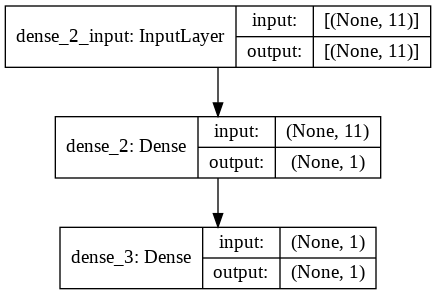

In [ ]:
keras.utils.plot_model(model, show_shapes = True)

In [ ]:
model.layers

In [ ]:
history = model.fit(train_prepared, train_labels, epochs = 100)

Epoch 1/100
34/34 [==============================] - 1s 1ms/step - loss: 13237.2979 - mae: 13237.2979 - mse: 321547936.0000
Epoch 2/100
34/34 [==============================] - 0s 1ms/step - loss: 13056.0771 - mae: 13056.0771 - mse: 316821344.0000
Epoch 3/100
34/34 [==============================] - 0s 1ms/step - loss: 12773.7529 - mae: 12773.7529 - mse: 309541600.0000
Epoch 4/100
34/34 [==============================] - 0s 1ms/step - loss: 12394.3936 - mae: 12394.3936 - mse: 300168480.0000
Epoch 5/100
34/34 [==============================] - 0s 1ms/step - loss: 11928.5996 - mae: 11928.5996 - mse: 288772800.0000
Epoch 6/100
34/34 [==============================] - 0s 1ms/step - loss: 11404.5098 - mae: 11404.5098 - mse: 275284352.0000
Epoch 7/100
34/34 [==============================] - 0s 1ms/step - loss: 10838.3828 - mae: 10838.3828 - mse: 260776192.0000
Epoch 8/100
34/34 [==============================] - 0s 1ms/step - loss: 10240.2979 - mae: 10240.2979 - mse: 244957728.0000
Epoch 9/

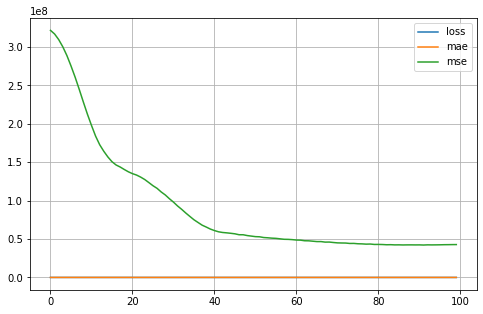

In [ ]:
#visualize the learning curves plot.

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()


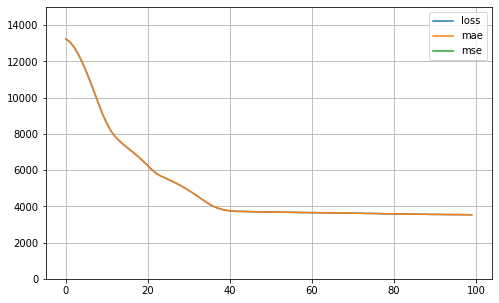

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 15000) # set the vertical range to [0-15000]
plt.show()

## Test

In [ ]:
test_prepared = full_pipeline.transform(strat_test_set)
test_dataset = test_prepared

In [ ]:
test_dataset.shape

(268, 11)

In [ ]:
test_labels.shape

(268,)

9/9 - 0s - loss: 3251.9575 - mae: 3251.9575 - mse: 37659888.0000
Testing set Mean Abs Error: 3251.96 expenses
You passed the challenge. Great job!


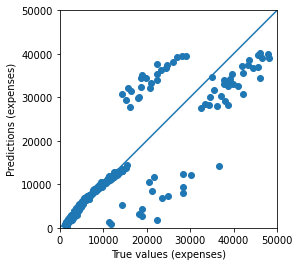

In [ ]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
